In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('/Users/mads/Documents/Python/kermut/')
from src.experiments.investigate_correlations import load_protein_mpnn_outputs
# from src.data.utils import load_conditional_probs
from src.model.utils import get_fitness_matrix, get_mutation_pair_matrix
from src import COLORS

In [3]:
import torch
import torch.nn as nn
from gpytorch.kernels import Kernel
import gpytorch

from src.experiments.investigate_correlations import load_protein_mpnn_outputs
from src.model.utils import Tokenizer
from src import GFP_WT, BLAT_ECOLX_WT

In [4]:
from src.model.kernel import KermutJSKernel, KermutJSD_RBFKernel, KermutHellingerKernel, KermutHellingerKernelMulti

In [5]:
from src.model.utils import hellinger_distance, Tokenizer

In [248]:
def load_conditional_probs(dataset: str, method: str = "esm2"):
    if method == "ProteinMPNN":
        conditional_probs_path = Path(
            "../data",
            "interim",
            dataset,
            "proteinmpnn",
            "conditional_probs_only",
            f"{dataset}.npz",
        )
        if dataset == "GFP":
            drop_index = [0]
        else:
            drop_index = None
        conditional_probs = load_protein_mpnn_outputs(
            conditional_probs_path, as_tensor=True, drop_index=drop_index
        )
    elif method == "esm2":
        conditional_probs_path = Path(
            "data", "interim", dataset, "esm2_masked_probs.pt"
        )
        conditional_probs = torch.load(conditional_probs_path)
    else:
        raise ValueError(f"Unknown method: {method}")

    return conditional_probs

In [249]:
class KermutHellingerKernelMulti(Kernel):
    """Kermut-distance based Hellinger kernel with support for multiple mutations."""

    def __init__(
        self,
        conditional_probs: torch.Tensor,
        wt_sequence: torch.LongTensor,
        p_B: float = 15.0,
        p_Q: float = 5.0,
        theta: float = 1.0,
        gamma: float = 1.0,
        learnable_transform: bool = False,
        learnable_hellinger: bool = False,
    ):
        super(KermutHellingerKernelMulti, self).__init__()
        self.learnable_transform = learnable_transform
        self.learnable_hellinger = learnable_hellinger

        # If learnable, pass parameters through softplus function to ensure positivity during learning
        if learnable_transform:
            self.register_parameter(
                name="_p_B", parameter=torch.nn.Parameter(torch.tensor(p_B))
            )
            self.register_parameter(
                name="_p_Q", parameter=torch.nn.Parameter(torch.tensor(p_Q))
            )
            self.transform_fn = nn.Softplus()
        else:
            assert p_B > 0 and p_Q > 0
            self.register_buffer("_p_B", torch.tensor(p_B))
            self.register_buffer("_p_Q", torch.tensor(p_Q))
            self.transform_fn = nn.Identity()

        if learnable_hellinger:
            self.register_parameter(
                name="_theta", parameter=torch.nn.Parameter(torch.tensor(theta))
            )
            self.register_parameter(
                name="_gamma", parameter=torch.nn.Parameter(torch.tensor(gamma))
            )
            self.hellinger_fn = nn.Softplus()
        else:
            assert theta > 0 and gamma > 0
            self.register_buffer("_theta", torch.tensor(theta))
            self.register_buffer("_gamma", torch.tensor(gamma))
            self.hellinger_fn = nn.Identity()

        self.register_buffer("conditional_probs", conditional_probs)
        self.register_buffer(
            "hellinger", hellinger_distance(conditional_probs, conditional_probs)
        )
        self.register_buffer("wt_sequence", wt_sequence)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor, **kwargs):
        # Indices where x1 and x2 differ to the WT. First column is batch, second is position.
        x1_idx = torch.argwhere(x1 != self.wt_sequence)
        x2_idx = torch.argwhere(x2 != self.wt_sequence)

        # Get batch and position indices of all mutation pairs (> N*N)
        batch_idx_x1 = x1_idx[:, 0].repeat_interleave(x2_idx[:, 0].shape[0])
        batch_idx_x2 = x2_idx[:, 0].repeat(x1_idx[:, 0].shape[0])
        pos_idx_x1 = x1_idx[:, 1].repeat_interleave(x2_idx[:, 1].shape[0])
        pos_idx_x2 = x2_idx[:, 1].repeat(x1_idx[:, 1].shape[0])

        # Extract and transform Hellinger distances
        hn = self.hellinger[pos_idx_x1, pos_idx_x2]
        k_hn = self.theta * torch.exp(-self.gamma * hn)

        # Extract conditional probabilities
        x1_toks = x1[batch_idx_x1, pos_idx_x1]
        x2_toks = x2[batch_idx_x2, pos_idx_x2]
        p_x1 = self.conditional_probs[pos_idx_x1, x1_toks]
        p_x2 = self.conditional_probs[pos_idx_x2, x2_toks]
        # k_p_x1x2 = 1 / (1 + self.p_Q * torch.exp(-self.p_B * p_x1 * p_x2)) # Why is it like this?
        k_p_x1x2 = 1 / (1 + self.p_Q * torch.exp(-self.p_B * p_x1)) * 1 / (1 + self.p_Q * torch.exp(-self.p_B * p_x2)) # Shouldn't it be like this?
        
        # Get unique indices and original placement
        unique_indices, inverse_indices = torch.unique(
            torch.cat((batch_idx_x1.unsqueeze(1), batch_idx_x2.unsqueeze(1)), -1),
            return_inverse=True,
            dim=0,
        )
        unique_indices = unique_indices.long()
        k_sum = torch.zeros(len(unique_indices))
        k_sum = torch.scatter_add(k_sum, 0, inverse_indices, k_hn * k_p_x1x2)
        output = torch.zeros(x1.size(0), x2.size(0))
        output[unique_indices[:, 0], unique_indices[:, 1]] = k_sum
        return output

    def get_params(self) -> dict:
        return {
            "p_B": self.p_B.item(),
            "p_Q": self.p_Q.item(),
            "theta": self.theta.item(),
            "gamma": self.gamma.item(),
        }

    @property
    def p_B(self):
        if self.learnable_transform:
            return self.transform_fn(self._p_B)
        return self._p_B

    @property
    def p_Q(self):
        if self.learnable_transform:
            return self.transform_fn(self._p_Q)
        return self._p_Q

    @property
    def theta(self):
        if self.learnable_hellinger:
            return self.hellinger_fn(self._theta)
        return self._theta

    @property
    def gamma(self):
        if self.learnable_hellinger:
            return self.hellinger_fn(self._gamma)
        return self._gamma


In [263]:
dataset = "GFP"
conditional_probs_method = "ProteinMPNN"
# conditional_probs_method = "esm2"
assay_path = Path("../data", "processed", f"{dataset}.tsv")

# Load data
conditional_probs = load_conditional_probs(dataset, conditional_probs_method)
df = pd.read_csv(assay_path, sep="\t")
df = df[df["n_muts"] <= 2]
np.random.seed(742)
idx_train = np.random.choice(len(df), 1000, replace=False)
idx_train = np.insert(idx_train, 0, 0)
idx_test = [idx for idx in range(len(df)) if idx not in idx_train]
idx_test = idx_test[:1000]
df_train = df.iloc[idx_train]
df_test = df.iloc[idx_test]
# df = df.iloc[:1000]
y = df_train["delta_fitness"].values
y = torch.tensor(y, dtype=torch.float32)

tokenizer = Tokenizer()
sequences = df_train["seq"]
tokens = tokenizer(sequences.to_list())
wt_sequence = tokenizer([GFP_WT])[0]
assert len(conditional_probs) == len(wt_sequence)

model_kwargs = {
    "conditional_probs": conditional_probs,
    "wt_sequence": wt_sequence,
    "p_B": 15.0,
    "p_Q": 5.0,
    "theta": 1.0,
    "gamma": 1.0,
    "learnable_transform": False,
    "learnable_hellinger": False,
}

tokens_test = tokenizer(df_test["seq"].to_list())
y_test = df_test["delta_fitness"].values
y_test = torch.tensor(y_test, dtype=torch.float32)


kernel = KermutHellingerKernelMulti(**model_kwargs)
out = kernel(tokens)  # IF PROFILING, INDENT
out = out.evaluate()


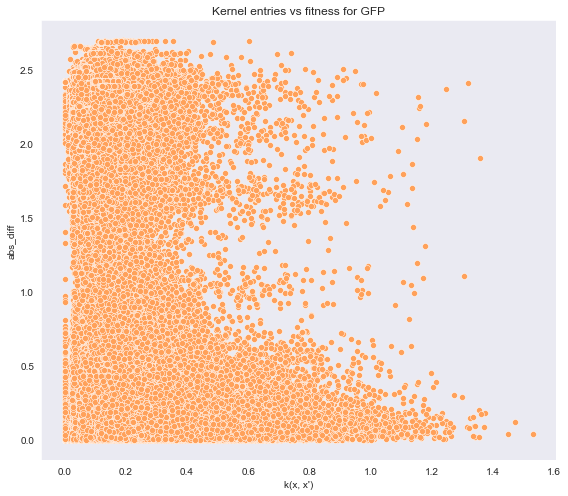

In [257]:
how = "abs_diff"
kernel_samples = out.detach().numpy()
y = get_fitness_matrix(df_train, how=how)
tril_mask = np.tril_indices_from(y, k=-1)
y = y[tril_mask]
kernel_samples = kernel_samples[tril_mask]

sns.set_style("dark")
fig, ax = plt.subplots(figsize=(8, 7))
sns.scatterplot(x=kernel_samples.flatten(), y=y.flatten(), color=COLORS[4], ax=ax)
ax.set_ylabel(f"{how}")
ax.set_xlabel("k(x, x')")
plt.title(f"Kernel entries vs fitness for {dataset}")
plt.tight_layout()
# plt.savefig(f"figures/{dataset}_fitness_vs_kernel_scatter_Hellinger.png")
plt.show()

In [258]:
print("Compare parts of the plot")
df_kernel = pd.DataFrame({"y": y.flatten(), "kernel": kernel_samples.flatten()})
print(df_kernel[df_kernel.y.gt(2)].shape[0] / df_kernel[df_kernel.y.lt(0.5)].shape[0])
print(df_kernel[df_kernel.y.gt(2) & df_kernel.kernel.lt(0.4)].shape[0] / df_kernel[df_kernel.y.lt(0.5) & df_kernel.kernel.lt(0.4)].shape[0])
print(df_kernel[df_kernel.y.gt(2) & df_kernel.kernel.gt(0.4)].shape[0] / df_kernel[df_kernel.y.lt(0.5) & df_kernel.kernel.gt(0.4)].shape[0])

Compare parts of the plot
0.1918128623989786
0.19975190235942522
0.0252663445304768


## Make a GP

In [264]:
training_iter = 5
train_x = tokens
train_y = y

# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

In [265]:
model_kwargs = {
    "conditional_probs": conditional_probs,
    "wt_sequence": wt_sequence,
    "p_B": 15.0,
    "p_Q": 5.0,
    "theta": 1.0,
    "gamma": 1.0,
    "learnable_transform": False,
    "learnable_hellinger": True,
}

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = KermutHellingerKernelMulti(**model_kwargs)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(tokens, y, likelihood)

In [266]:
# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

In [195]:
# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = likelihood(model(tokens_test))

In [238]:
preds = observed_pred.mean.detach().numpy()
vals = y_test.numpy()

In [244]:
preds.shape

(1001,)

In [240]:
np.corrcoef(preds, vals)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1001 and the array at index 1 has size 1000

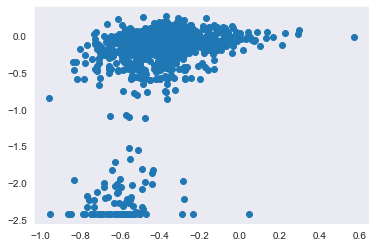

In [198]:
plt.scatter(preds, vals)
plt.show()